# Yolo v3 and Keras Video and object detection and tracker

# Observation:
# Pretrained Yolo v3 is faster than the pretrained FasterRCNN with RestNet50 backbone, but detects less number of objects for the same image and same confidence (and threshold ) levels.
# FatserRCNN detected 94 objects with confidence above 25%, where as yolov3 detected 69 objects with even less confidence of 20%
# Both have some false/incorrect detection/labeling problem

In [3]:
################################################################################################################################
# import the necessary packages
################################################################################################################################
import numpy as np
#import argparse
import time
import cv2
import os
from PIL import Image
from IPython.display import clear_output
%pylab inline 
import imutils

Populating the interactive namespace from numpy and matplotlib


In [4]:
################################################################################################################################
# load the COCO class labels 
################################################################################################################################
labelsPath =  "./coco.names"
LABELS = open(labelsPath).read().strip().split("\n")
#LABELS

In [5]:
################################################################################################################################
# define list of colors to represent each possible class label
################################################################################################################################
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")


In [8]:
################################################################################################################################
# define path for yolov3 model config and YOLO model weights which was trained on coco
################################################################################################################################
weightsPath =  "yolov3.weights"
configPath = "yolov3.cfg"
#weightsPath = 'yolo5m_best_weights.pt'

In [9]:
################################################################################################################################
# load our YOLO object detector trained on COCO dataset (with 80 classes) 
################################################################################################################################
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)


In [10]:
################################################################################################################################
# determine only the *output* layer names that we need from YOLO
################################################################################################################################
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
layer_names 

['yolo_82', 'yolo_94', 'yolo_106']

In [24]:
################################################################################################################################
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
# loop over each of the layer outputs
# loop over each of the detections
# extract the class ID and confidence (i.e., probability) of
# the current object detection
# filter out weak predictions by ensuring the detected
# probability is greater than the minimum probability
# scale the bounding box coordinates back relative to the
# size of the image, keeping in mind that YOLO actually
# returns the center (x, y)-coordinates of the bounding
# box followed by the boxes' width and height
# use the center (x, y)-coordinates to derive the top and
# and left corner of the bounding box
# update our list of bounding box coordinates, confidences, and class IDs
# loop over the indexes we are keeping
# type indicator 'V' for Video and 'I' for Image
################################################################################################################################
def show_processed_image(inp_image,file_to_write=None,Type='I',conf=0.5):
    
    if (Type=='V' or Type=='I'):
        pass
    else:
        print('Please enter the right "Type"; "V" for Video Frame, "I" for Image Path')
        raise ValueError
        return
    image = inp_image 
    if Type=='I':
        image = cv2.imread(inp_image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    (H, W) = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    net.setInput(blob)    
    layerOutputs = net.forward(layer_names)
    boxes = []
    confidences = []
    classIDs = []
    
    for output in layerOutputs:
       
        for detection in output:
            
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            
            if confidence > conf :                                 
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
               
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf ,0.3)
    if len(idxs) > 0:
       
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
        
            # draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)  # 2 for image 1 for video
            text = "{}: {:.2f}".format(LABELS[classIDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,.3, color, 1)  #textsize=1.5& 5 for image,
                                                                                        #.3 &1for videos/cars
    
    plt.figure(figsize=(16,12))
    if Type=='V':
          title("Video Stream in Progress.... "+str(int((j/(num_frames-1))*100))+'% complete',fontweight='bold',fontsize=14)
          if (j==num_frames-1):
             title("Video Stream is "+str(int((j/(num_frames-1))*100))+'% complete',fontweight='bold',fontsize=14)
    elif Type=='I':
          title(str(len(idxs)+1)+" Objects detected from this Image with confidence above "+\
                str(np.round(np.min(confidences)*100,2))+'%'\
               ,fontweight='bold',fontsize=14)
    plt.imshow(image,extent=(1.0,1350.0,10.0,800.0))
    show()
    
    if file_to_write != None:
          image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
          cv2.imwrite(file_to_write+str(j)+'.jpg',image)
    clear_output(wait=True)

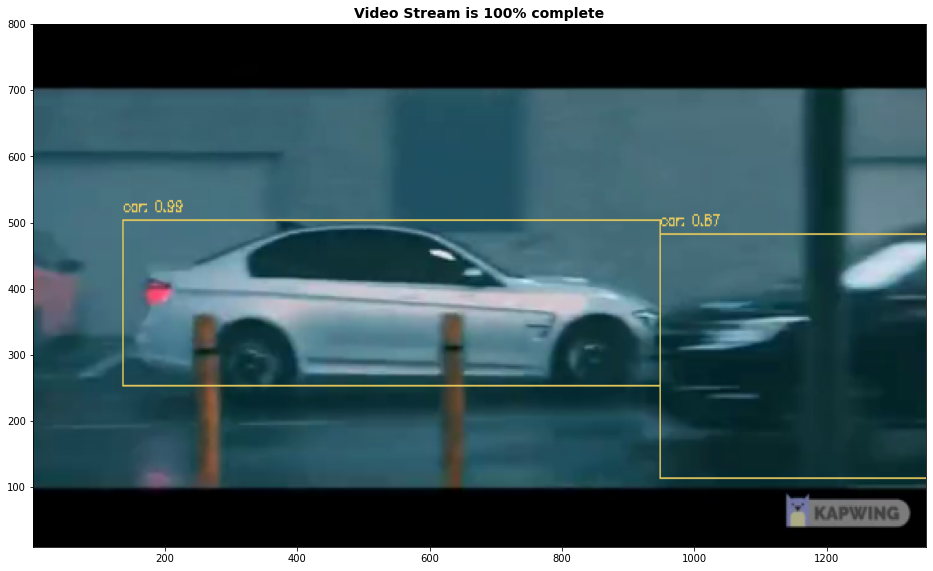

In [26]:
################################################################################################################################
# detections on couple of speeding cars  
################################################################################################################################
num_frames=138   # 138
videopath = './videos/car_chase.mp4' 
vid = cv2.VideoCapture(videopath)
for j in range(num_frames):
    _, frame = vid.read()    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame,(650,300))
    file_to_write='./Car_Chase/car_chase'
    show_processed_image(frame,Type='V')

<video width=500, height=256, controls src="./Videos/keras_yolo_car_chase.mp4" />

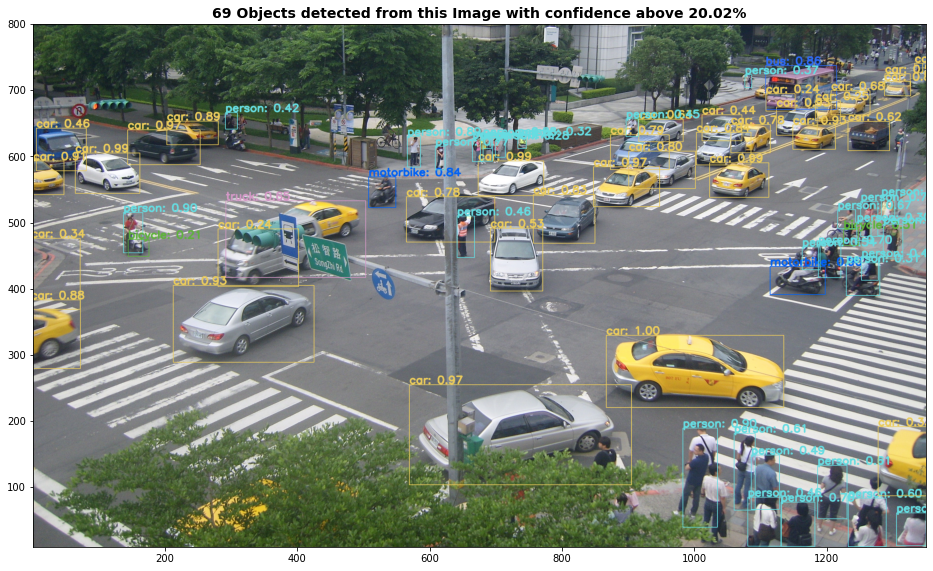

In [21]:
################################################################################################################################
# detections on a busy US Intersection
################################################################################################################################
show_processed_image("./images/Intersection-Counts.jpg",Type='I',conf=0.1)